# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

#### 4.0 Utils

In [5]:
from unityagents import UnityEnvironment
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import random
from collections import namedtuple, deque

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


#### 4.1 Model Network

In [6]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return -lim, lim

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, fc1_size=64, fc2_size=64, seed=1):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.state_size  = state_size
        self.action_size = action_size

        self.fc1    = nn.Linear(self.state_size, fc1_size)
        self.fc2    = nn.Linear(fc1_size, fc2_size)
        self.fc_out = nn.Linear(fc2_size, self.action_size)
        self.reset_parameters()


    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc_out.weight.data.uniform_(-3e-3, 3e-3)
        

    def forward(self, state):
        """Build a network that maps states -> actions."""

        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.tanh(self.fc_out(x))

        return x

class Critic(nn.Module):
    """Critc (Value) Model."""

    def __init__(self, state_size, action_size, fc1_size=64, fc2_size=64, seed=1):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_size (int): Number of nodes in the first hidden layer
            fc2_size (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.state_size  = state_size
        self.action_size = action_size

        self.fc1    = nn.Linear(state_size + action_size, fc1_size)
        self.fc2    = nn.Linear(fc1_size, fc2_size)
        self.fc3    = nn.Linear(fc2_size, 1)
        self.reset_parameters()
        

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)


    def forward(self, state, action):
        """Build a critic (value) network that maps states -> values."""

        x = F.relu(self.fc1(torch.cat((state, action), dim=1)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x


#### 4.2 Agents

In [7]:
BUFFER_SIZE = int(1e5)   # replay buffer size
BATCH_SIZE = 250         # minibatch size
GAMMA = 0.99             # discount factor
TAU = 1e-3               # for soft update of target parameters
LR_A = 1e-4              # learning rate 
LR_C = 1e-3              # learning rate 
UPDATE_EVERY = 1         # how often to update the network

FC1_SIZE = 200           # Size of the first hidden layer in the MLP
FC2_SIZE = 150           # Size of the second hidden layer in the MLP

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, num_agents, seed=1):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        super(Agent, self).__init__()
        
        self.seed = random.seed(seed)
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents

        # Networks
        self.actor_local   = Actor(state_size, action_size, fc1_size=FC1_SIZE, fc2_size=FC2_SIZE, seed=seed).to(device) 
        self.actor_target  = Actor(state_size, action_size, fc1_size=FC1_SIZE, fc2_size=FC2_SIZE, seed=seed).to(device)
        self.critic_local  = Critic(num_agents*state_size, num_agents*action_size, fc1_size=FC1_SIZE, fc2_size=FC2_SIZE, seed=seed).to(device)
        self.critic_target = Critic(num_agents*state_size, num_agents*action_size, fc1_size=FC1_SIZE, fc2_size=FC2_SIZE, seed=seed).to(device)
        
        # Optimizers
        self.actor_opt  = optim.Adam(self.actor_local.parameters(), lr=LR_A)
        self.critic_opt = optim.Adam(self.critic_local.parameters(), lr=LR_C)
        
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state)
        self.actor_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return action.cpu().data.numpy().squeeze()
        else:
            return np.random.randn(self.action_size)

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states_list, actions_list, rewards, next_states_list, dones = experiences

        states_tensor = torch.cat(states_list, dim=1)
        actions_tensor = torch.cat(actions_list, dim=1)
        next_states_tensor = torch.cat(next_states_list, dim=1)
        
        next_actions_list = [self.actor_target(states) for states in states_list]
        next_actions_tensor = torch.cat(next_actions_list, dim=1) 
        
        next_q = self.critic_target(next_states_tensor, next_actions_tensor)
        next_q = rewards + (gamma * next_q * (1 - dones))
        
        # Compute critic loss
        q = self.critic_local(states_tensor, actions_tensor)
        critic_loss = F.mse_loss(q, next_q)
        
        # Minimize loss at critic
        self.critic_opt.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_opt.step()
        
        # Compute actor/policy loss
        actions_list = [self.actor_local(states) for states in states_list]
        actions_tensor = torch.cat(actions_list, dim=1)
        policy_loss = -self.critic_local(states_tensor.detach(), actions_tensor).mean()
        
        # Minimize loss at actor
        self.actor_opt.zero_grad()
        policy_loss.backward()
        self.actor_opt.step()

        
class MADDPG:
    """Multi-Agent class for DDPG Agents"""
    
    def __init__(self, state_size, action_size, num_agents, seed, tau):
        
        self.maddpg_agent = [Agent(state_size, action_size, num_agents, seed) for i in range(num_agents)]

        self.num_agents = num_agents
        self.tau = tau
        self.iter = 0

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, num_agents, seed)

        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def act(self, all_agent_states, eps=0.):
        """get actions from all agents in the MADDPG object"""
        actions = [agent.act(state, eps) for agent, state in zip(self.maddpg_agent, all_agent_states)]
        return actions

    def step(self, states, actions, rewards, next_states, dones):

        # Save experience in replay memory
        self.memory.add(states, actions, rewards, next_states, dones)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                for agent in self.maddpg_agent:
                    experiences = self.memory.sample()
                    agent.learn(experiences, GAMMA)
                # soft-update of the target networks
                self.update_targets()

    def update_targets(self):
        """soft update targets"""
        self.iter += 1
        for agent in self.maddpg_agent:
            self.soft_update(agent.actor_local, agent.actor_target, self.tau)
            self.soft_update(agent.critic_local, agent.critic_target, self.tau)
 
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def save_weights(self):
        for index, agent in enumerate(self.maddpg_agent):
            torch.save(agent.actor_local.state_dict(), 'agent{}_checkpoint_actor.pth'.format(index+1))
            torch.save(agent.actor_target.state_dict(), 'agent{}_checkpoint_actor_target.pth'.format(index+1))
            torch.save(agent.critic_local.state_dict(), 'agent{}_checkpoint_critic.pth'.format(index+1))
            torch.save(agent.critic_target.state_dict(), 'agent{}_checkpoint_critic.target.pth'.format(index+1))
    
    def load_weights(self):
        for index, agent in enumerate(self.maddpg_agent):
            agent.actor_local.load_state_dict(torch.load('agent{}_checkpoint_actor.pth'.format(index+1)))
            agent.actor_target.load_state_dict(torch.load('agent{}_checkpoint_actor_target.pth'.format(index+1)))
            agent.critic_local.load_state_dict(torch.load('agent{}_checkpoint_critic.pth'.format(index+1)))
            agent.critic_target.load_state_dict(torch.load('agent{}_checkpoint_critic.target.pth'.format(index+1)))
    

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, num_agents, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.num_agents = num_agents
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states_list = [torch.from_numpy(np.vstack([e.state[i] for e in experiences if e is not None])).float().to(device) for i in range(self.num_agents)]
        actions_list = [torch.from_numpy(np.vstack([e.action[i] for e in experiences if e is not None])).float().to(device) for i in range(self.num_agents)]
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states_list = [torch.from_numpy(np.vstack([e.next_state[i] for e in experiences if e is not None])).float().to(device) for i in range(self.num_agents)]
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states_list, actions_list, rewards, next_states_list, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

#### 4.3 Training

Episode 100	Average Score: 0.01
Episode 200	Average Score: 0.01
Episode 300	Average Score: 0.03
Episode 400	Average Score: 0.02
Episode 500	Average Score: 0.04
Episode 600	Average Score: 0.06
Episode 700	Average Score: 0.12
Solved in episode: 783 	Average score: 0.525


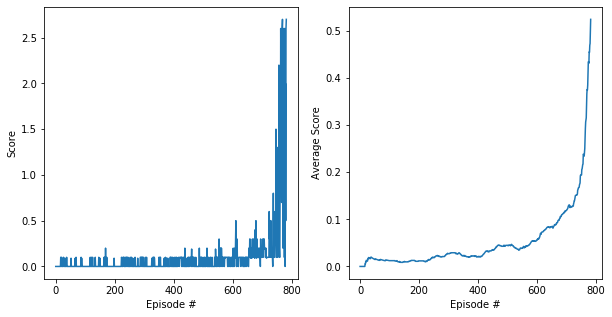

In [8]:
def ma_train(agents, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_deque = deque(maxlen=100)   # last 100 scores
    average_scores_list = []
    eps = eps_start                    # initialize epsilon

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations 
        score = np.zeros(num_agents)
        while True:
            actions = agents.act(states, eps)
            actions = np.clip(actions, -1, 1)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards                 
            dones = env_info.local_done 
            agents.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if np.any(dones):
                break 
        score_max = np.max(score)
        scores.append(score_max)
        scores_deque.append(score_max)
        average_score = np.mean(scores_deque)
        average_scores_list.append(average_score)
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average_score))

        if average_score >= 0.5:
            agents.save_weights()
            print("\rSolved in episode: {} \tAverage score: {:.3f}".format(i_episode , average_score))
            break

    return scores , average_scores_list

agents = MADDPG(state_size=24, action_size=2, num_agents=2, seed=0, tau=TAU)
scores, average_scores = ma_train(agents, n_episodes=2000, max_t=10)

# plot the scores
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.plot(np.arange(len(scores)), scores)
ax1.set_ylabel('Score')
ax1.set_xlabel('Episode #')
ax2 = fig.add_subplot(122)
ax2.plot(np.arange(len(average_scores)), average_scores)
ax2.set_ylabel('Average Score')
ax2.set_xlabel('Episode #')
plt.show()

#### 4.4 Run the Agents

In [9]:
agents.load_weights()

for i in range(1, 2):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agents.act(states)                       # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 2.7000000402331352


In [10]:
env.close()